In [335]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import seaborn as sns
import json
from io import StringIO
import importlib

In [336]:
import molten_data_common_lib
importlib.reload(molten_data_common_lib)
from molten_data_common_lib import (glob_file_list , load_json_from_file, merge_dicts, plot_groups, 
                                    get_varying_column_names, filter_dataframe,
                                    load_json_records_as_dataframe)

In [337]:
src_files = []
# src_files += ['../p3_test_driver/data/results/json/*cfa64651-ac9a-4ab4-b4f1-0fa24cfe3fdc*.json']
src_files += ['../p3_test_driver/data/results/json/*.json']
raw_df = load_json_records_as_dataframe(src=src_files, ignore_error=True)

Loading records from 39 files...


In [338]:
#raw_df.iloc[0].driver['client']['persistence']

In [339]:
def clean_result(result):
    try:
        r = result.copy()
        r['driverName'] = r['driver']['name']
        r = merge_dicts(r, r['driver']['client']['persistence'])
        r = merge_dicts(r, r['workload'])
        del r['workload']
        r = merge_dicts(r, r['omb_results'])
        for k in list(r.keys()):
            if 'Quantiles' in k:
                r[k] = pd.Series(data=[float(q) for q in r[k].keys()], index=list(r[k].values())).sort_index() / 100
            elif isinstance(r[k], list) and 'Rate' in k:
                r[k] = pd.Series(r[k])
                r['%sMean' % k] = r[k].mean()
        r['numWorkloadWorkers'] = int(r.get('numWorkers', 0))
        r['throttleEventsPerSec'] = r['producerRate']
        r['publishRateEventsPerSecMean'] = r['publishRateMean']
        r['publishRateMBPerSecMean'] = r['publishRateMean'] * r['messageSize'] * 1e-6
        r['publishLatencyMsAvg'] = r['aggregatedPublishLatencyAvg']
        r['publishLatencyMs99Pct'] = r['aggregatedPublishLatency99pct']
        r['endToEndLatencyMsAvg'] = r['aggregatedEndToEndLatencyAvg']
        r['endToEndLatencyMs99Pct'] = r['aggregatedEndToEndLatency99pct']
        return pd.Series(r)
    except Exception as e:
        print('ERROR: %s: %s' % (r['test_uuid'], e))
r = clean_result(raw_df.iloc[0])
pd.DataFrame(r)

,0
build,False
command_timed_out,False
driver,Pulsar
elapsed_sec,370.363
error,False
...,...
publishRateMBPerSecMean,30.073
publishLatencyMsAvg,2.85502
publishLatencyMs99Pct,4.193
endToEndLatencyMsAvg,8.60811


In [340]:
clean_df = raw_df.apply(clean_result, axis=1)
clean_df = clean_df.set_index('test_uuid', drop=False)
clean_df = clean_df[clean_df.error==False]
clean_df = clean_df.sort_values(['utc_begin'])

ERROR: 47e915a0-0587-461e-bb77-b513da507827: 'float' object is not iterable
ERROR: 206ae585-349e-4c11-a06e-4c0d4ae640fe: 'float' object is not iterable
ERROR: d9aac910-c6db-497a-a02b-ead8a626745f: 'float' object is not iterable
ERROR: 564733b2-b071-4a02-8350-f82e636b6bfa: 'float' object is not iterable


In [341]:
clean_df.columns.values

array(['build', 'command_timed_out', 'driver', 'elapsed_sec', 'error',
       'errors', 'exit_code', 'git_commit', 'loaded_filename',
       'localWorker', 'max_test_attempts', 'noop', 'numWorkers',
       'omb_results', 'omb_workers', 'output', 'print_output',
       'record_utc', 'record_uuid', 'result_filename', 'run_as_test',
       'sequence_in_test_batch', 'size_of_test_batch', 'ssh_host',
       'ssh_identity_file', 'ssh_user', 'status_html', 'tarball', 'test',
       'test_attempt', 'test_batch_uuid', 'test_desc',
       'test_driver_log_filename', 'test_driver_version', 'test_uuid',
       'undeploy', 'utc_begin', 'utc_end', 'driverName', 'ackQuorum',
       'deduplicationEnabled', 'ensembleSize', 'writeQuorum',
       'consumerBacklogSizeGB', 'consumerPerSubscription',
       'keyDistributor', 'messageSize', 'name', 'partitionsPerTopic',
       'payloadFile', 'producerRate', 'producersPerTopic',
       'subscriptionsPerTopic', 'testDurationMinutes', 'topics',
       'aggregat

In [342]:
info_cols = [
    'numWorkers',
    'topics',
    'partitionsPerTopic',
    'producersPerTopic',
    'subscriptionsPerTopic',
    'consumerPerSubscription',
    'testDurationMinutes',
    'keyDistributor',
    'git_commit',    
]

In [343]:
cols = [
    'messageSize',
    'numWorkloadWorkers',
    'producersPerTopic',
    'partitionsPerTopic',
    'testDurationMinutes',
    'subscriptionsPerTopic',
    'consumerPerSubscription',
    'ackQuorum',
    'throttleEventsPerSec',
    #'deduplicationEnabled',
    'publishRateEventsPerSecMean',
    'publishRateMBPerSecMean',
    'publishLatencyMsAvg',
    'publishLatencyMs99Pct',
    'endToEndLatencyMsAvg',
    'endToEndLatencyMs99Pct',
    'utc_begin',
]

In [344]:
clean_df[cols].tail(2).T

test_uuid,172af457-1917-4129-a7a9-a2bb73b1f83c,f6030c7e-0bd4-49c9-8448-d3ca9458e9e4
messageSize,100,100
numWorkloadWorkers,4,4
producersPerTopic,4,4
partitionsPerTopic,16,16
testDurationMinutes,5,5
subscriptionsPerTopic,1,1
consumerPerSubscription,16,16
ackQuorum,2,2
throttleEventsPerSec,3e+06,50000
publishRateEventsPerSecMean,3.09157e+06,50029.7


In [345]:
#clean_df[cols].to_csv('openmessaging-benchmark-results.csv')

In [346]:
df = clean_df[cols]
df = df.sort_values(['messageSize','numWorkloadWorkers','producersPerTopic','throttleEventsPerSec','utc_begin'])
df.head()

,messageSize,numWorkloadWorkers,producersPerTopic,partitionsPerTopic,testDurationMinutes,subscriptionsPerTopic,consumerPerSubscription,ackQuorum,throttleEventsPerSec,publishRateEventsPerSecMean,publishRateMBPerSecMean,publishLatencyMsAvg,publishLatencyMs99Pct,endToEndLatencyMsAvg,endToEndLatencyMs99Pct,utc_begin
test_uuid,,,,,,,,,,,,,,,,
22b9ab65-0c50-4180-a6d9-454998ab5bb8,100.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,-1.0,4.034625e+05,40.346246,0.000000,0.000,0.000000,0.000,2019-09-29T17:05:37.792852
40bdbe3c-18ed-48b8-a88e-cd719f04eda2,100.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,-1.0,1.225671e+06,122.567110,4.041255,4.867,0.000000,0.000,2019-09-29T17:14:05.238724
79b21aa6-9b35-4a31-8ef1-94fb8664c41b,100.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,-1.0,1.367346e+06,136.734587,4.143735,4.963,0.000000,0.000,2019-09-29T17:21:08.078498
25ac50a5-8fb3-451f-b925-57ab2f54b158,100.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,-1.0,9.526471e+05,95.264706,7.506097,35.051,13561.878498,15385.023,2019-09-29T17:31:52.498934
7a8c6fe9-b353-4e35-9a6b-24e0cb4ecf28,100.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,-1.0,9.930919e+05,99.309189,7.174837,33.027,16009.838414,21974.015,2019-09-29T17:34:39.332250


In [347]:
messageSize = 100
filt_df = filter_dataframe(
    clean_df,
    driverName='Pulsar',
    messageSize=messageSize, 
    numWorkloadWorkers=4, 
    producersPerTopic=4,
    partitionsPerTopic=16,
    deduplicationEnabled=True,
    testDurationMinutes=5,
    
)
filt_df[cols].sort_values(['publishRateMBPerSecMean'], ascending=False)

,messageSize,numWorkloadWorkers,producersPerTopic,partitionsPerTopic,testDurationMinutes,subscriptionsPerTopic,consumerPerSubscription,ackQuorum,throttleEventsPerSec,publishRateEventsPerSecMean,publishRateMBPerSecMean,publishLatencyMsAvg,publishLatencyMs99Pct,endToEndLatencyMsAvg,endToEndLatencyMs99Pct,utc_begin
test_uuid,,,,,,,,,,,,,,,,
733715d0-3ad1-4f6a-8f0e-96d2532eee53,100.0,4.0,4.0,16.0,5.0,1.0,16.0,2.0,-1.0,3.949428e+06,394.942759,5.373298,36.840,41.848294,289.001,2019-09-30T01:22:17.955975
4965adf1-967e-4405-a67d-639a6944fb84,100.0,4.0,4.0,16.0,5.0,1.0,16.0,2.0,-1.0,3.567640e+06,356.764024,5.709695,47.684,32.346984,234.000,2019-09-30T00:31:21.704587
172af457-1917-4129-a7a9-a2bb73b1f83c,100.0,4.0,4.0,16.0,5.0,1.0,16.0,2.0,3000000.0,3.091569e+06,309.156866,5.436944,42.516,29.457003,244.000,2019-09-30T03:22:30.598279
96fa17df-60fc-4119-9504-9be6a5f767c7,100.0,4.0,4.0,16.0,5.0,1.0,16.0,2.0,1000000.0,1.000633e+06,100.063252,3.438818,4.950,10.972540,113.000,2019-09-30T03:16:15.551788
5434362c-40d2-4b74-b4a0-15f9f5ca64b0,100.0,4.0,4.0,16.0,5.0,1.0,16.0,2.0,300000.0,3.007295e+05,30.072954,2.855023,4.193,8.608106,14.000,2019-09-30T03:10:00.907993
e7726494-2043-46bf-a139-3c002c6845b4,100.0,4.0,4.0,16.0,5.0,1.0,16.0,2.0,100000.0,1.000495e+05,10.004947,2.681829,4.053,7.858433,14.000,2019-09-30T03:03:46.406648
f6030c7e-0bd4-49c9-8448-d3ca9458e9e4,100.0,4.0,4.0,16.0,5.0,1.0,16.0,2.0,50000.0,5.002974e+04,5.002974,2.610793,4.011,7.823805,13.000,2019-09-30T04:06:06.428653
d24f7925-d688-4370-a12a-d5949bb5890e,100.0,4.0,4.0,16.0,5.0,1.0,16.0,2.0,30000.0,3.006238e+04,3.006238,2.642269,4.010,7.748417,14.000,2019-09-30T02:57:31.478057
2d9b3507-2562-4c81-a4f7-610ac9819ddc,100.0,4.0,4.0,16.0,5.0,1.0,16.0,2.0,10000.0,1.000857e+04,1.000857,2.537357,4.001,7.783800,13.000,2019-09-30T02:51:16.288735


In [348]:
plot_df = (filt_df
    .set_index(['publishRateMBPerSecMean'])
    .sort_index()
    [[
        'aggregatedPublishLatency50pct',
        'aggregatedPublishLatency95pct',
        'aggregatedPublishLatency99pct',
        'aggregatedEndToEndLatency50pct',
        'aggregatedEndToEndLatency95pct',
        'aggregatedEndToEndLatency99pct',
        'test_uuid',
    ]]
    .rename(columns=dict(
        aggregatedPublishLatency50pct='Publish Latency p50',
        aggregatedPublishLatency95pct='Publish Latency p95',
        aggregatedPublishLatency99pct='Publish Latency p99',
        aggregatedEndToEndLatency50pct='E2E Latency p50',
        aggregatedEndToEndLatency95pct='E2E Latency p95',
        aggregatedEndToEndLatency99pct='E2E Latency p99',
    ))
    )
plot_df.index.name = 'Publish Throughput (MB/s)'
plot_df

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Publish Throughput (MB/s),,,,,,,
0.003002,2.843,3.875,4.016,3.0,12.0,13.000,786b43b1-e105-4cdf-9278-d0f210a6374d
0.010017,2.827,3.853,3.967,3.0,4.0,4.000,2adaacb1-61c9-4a7c-81f1-f22f34187608
0.300447,2.575,3.803,3.977,7.0,12.0,13.000,ba7ea40e-da95-4107-ae8e-40c67144223d
1.000857,2.511,3.811,4.001,8.0,12.0,13.000,2d9b3507-2562-4c81-a4f7-610ac9819ddc
3.006238,2.611,3.846,4.010,8.0,13.0,14.000,d24f7925-d688-4370-a12a-d5949bb5890e
5.002974,2.589,3.835,4.011,8.0,13.0,13.000,f6030c7e-0bd4-49c9-8448-d3ca9458e9e4
10.004947,2.660,3.894,4.053,8.0,13.0,14.000,e7726494-2043-46bf-a139-3c002c6845b4
30.072954,2.827,4.034,4.193,8.0,13.0,14.000,5434362c-40d2-4b74-b4a0-15f9f5ca64b0
100.063252,3.231,4.484,4.950,9.0,14.0,113.000,96fa17df-60fc-4119-9504-9be6a5f767c7


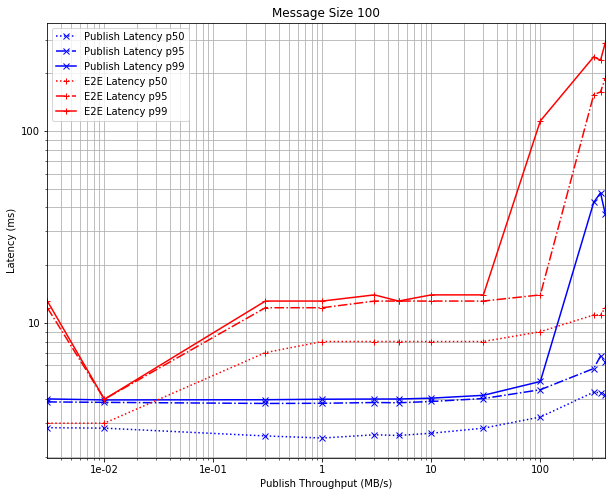

In [363]:
title = 'Message Size %d' % (messageSize)
ax = plot_df.plot(    
    logx=True, 
    logy=True,
    figsize=(10,8), 
    grid=True, 
    title=title, 
    style=['x:b','x-.b','x-b','+:r','+-.r','+-r'])
ax.set_ylabel('Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax.xaxis.set_major_formatter(tick_formatter)
ax.yaxis.set_major_formatter(tick_formatter)
ax.grid('on', which='both', axis='both')

In [350]:
filt_df[info_cols].drop_duplicates().T

test_uuid,4965adf1-967e-4405-a67d-639a6944fb84,786b43b1-e105-4cdf-9278-d0f210a6374d
numWorkers,4,4
topics,1,1
partitionsPerTopic,16,16
producersPerTopic,4,4
subscriptionsPerTopic,1,1
consumerPerSubscription,16,16
testDurationMinutes,5,5
keyDistributor,NO_KEY,NO_KEY
git_commit,7cab87a p3 test driver now supports ssh to dri...,7cab87a p3 test driver now supports ssh to driver


In [351]:
# plot_groups(
#     filt_df, 
#     x_col='publishRateEventsPerSecMean',
#     y_col='publishLatencyMs99Pct',
#     group_by_columns=['partitionsPerTopic', 'messageSize'],
#     semilogx=True,
# #     ylim=[0,100],
# );

# Analyze Latency Distribution

In [352]:
df = clean_df
df = df[df.test_uuid=='cfa64651-ac9a-4ab4-b4f1-0fa24cfe3fdc']
t = df.iloc[0]
t

build                        False
command_timed_out            False
driver                      Pulsar
elapsed_sec                972.281
error                        False
                            ...   
publishRateMBPerSecMean    5.00089
publishLatencyMsAvg        2.90988
publishLatencyMs99Pct         4.09
endToEndLatencyMsAvg       3.42642
endToEndLatencyMs99Pct          12
Name: cfa64651-ac9a-4ab4-b4f1-0fa24cfe3fdc, Length: 103, dtype: object

In [353]:
# Cumulative Distribution Function
cdf = t.aggregatedPublishLatencyQuantiles
cdf

0.645      4.424505e-08
1.003      5.024490e-03
1.169      1.001436e-02
1.320      1.500031e-02
1.468      2.003252e-02
               ...     
220.531    9.999999e-01
220.532    9.999999e-01
220.533    1.000000e+00
220.534    1.000000e+00
222.364    1.000000e+00
Length: 1640, dtype: float64

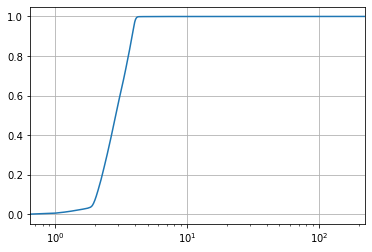

In [354]:
cdf.plot(logx=True, grid=True);

In [355]:
# Probability Distribution Function (latency histogram)
pdf = pd.Series(index=cdf.index, data=np.gradient(cdf, cdf.index.values))
pdf

0.645      1.403476e-02
1.003      2.498292e-02
1.169      3.160953e-02
1.320      3.351541e-02
1.468      3.376274e-02
               ...     
220.531    4.424505e-05
220.532    4.424505e-05
220.533    3.318379e-05
220.534    2.211045e-05
222.364    1.208881e-08
Length: 1640, dtype: float64

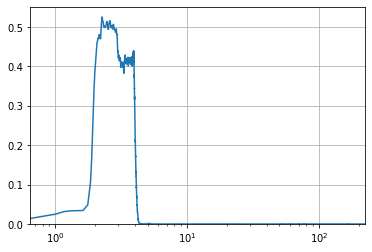

In [356]:
pdf.plot(logx=True, logy=False, grid=True, ylim=[0,None]);

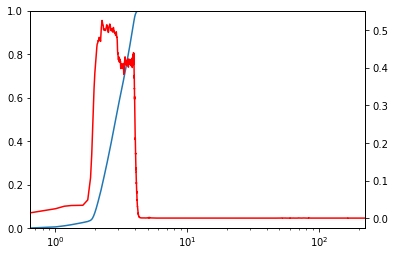

In [357]:
fig0, ax0 = plt.subplots()
ax1 = ax0.twinx()
cdf.plot(ax=ax0, logx=True, ylim=[0,1])
pdf.plot(secondary_y=True, ylim=[0,None], ax=ax1, style='r')
plt.show()
plt.close()

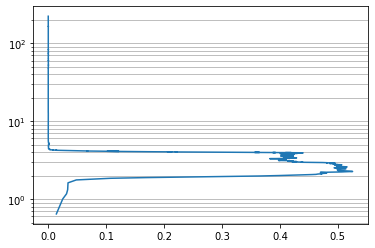

In [358]:
fig0, ax0 = plt.subplots()
ax0.plot(pdf.values, pdf.index.values)
ax0.grid('on', which='both', axis='y')
ax0.semilogy(True);